# Project 4: West Nile Virus
**Members**: DJ  | Nazira  |  Sean  |  Shuyi

Organisation of codebooks
1. Data collection, EDA, Feature engineering
    * ```spray```, ```weather```, ```train``` and ```test``` datasets
2. Pre-processing
3. Model tuning and conclusions

# Problem Statement

**What we are looking to solve**: We are looking to improve the cost-effectiveness of existing strategies in tackling adult mosquito populations and mitigating the spread of the West Nile Virus (WMV). 

**How we plan on solving it**: We will build a machine learning algorithm to predict the presence of the West Nile Virus, using data on past weather conditions and locations where the WMV was detected.

**Proposed Implementation**: Our tool can be employed to effectively carry out targeted spraying of specific at-risk neighbourhoods. This will ultimately help the City of Chicago save costs and better re-allocate resources in its task to prevent / mitigate the spread of the WMV.

# Data Collection and EDA

In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from geopy.distance import geodesic

In [2]:
# Ensuring our notebook remains tidy
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Setting our seaborn style and colour palette
sns.set_style('darkgrid')
sns.set_palette('icefire')

In [4]:
# Creating a custom function to kick-start the EDA process
def eda_clean(df):
    print('Dataset Statistics:')
    print(f'Shape of dataframe: {df.shape}')
    print('--------------------------------------')
    print(f'Null values in dataframe: {df.isna().sum().sum()}')
    print('--------------------------------------')
    print(f'% of Null values in dataframe: {round(((df.isna().sum().sum())/(df.shape[0])) * 100, 2)}%')
    print('--------------------------------------')
    print(f"Total duplicate rows: {df[df.duplicated()].shape[0]}")
    print('--------------------------------------')
    print(f"% duplicate rows: {round(df[df.duplicated()].shape[0] / df.shape[0] * 100, 2)}%")
    print(f'\nColumn names: {df.columns}')
    print('\nVariable Types')
    print(f"Columns Count: \n{df.dtypes.value_counts()}")

## A pre-cursor check on ```train``` and ```test``` datasets overlaps

Every year from late-May to early-October, public health workers in Chicago setup mosquito traps scattered across the city. Every week from Monday through Wednesday, these traps collect mosquitos, and the mosquitos are tested for the presence of West Nile virus before the end of the week. The test results include the number of mosquitos, the mosquitos species, and whether or not West Nile virus is present in the cohort.

These test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50. 

Some traps are "satellite traps". These are traps that are set up near (usually within 6 blocks) an established trap to enhance surveillance efforts. Satellite traps are postfixed with letters. For example, T220A is a satellite trap to T220. 

Please note that not all the locations are tested at all times. Also, records exist only when a particular species of mosquitos is found at a certain trap at a certain time. In the test set, we ask you for all combinations/permutations of possible predictions and are only scoring the observed ones.

**What we need to do**: The training set consists of data from 2007, 2009, 2011, and 2013, while in the test set we will need to predict the test results for 2008, 2010, 2012, and 2014.

In [5]:
# Read train and test datasets
train = pd.read_csv('../data/raw/train.csv', parse_dates=['Date'])
test = pd.read_csv('../data/raw/test.csv', parse_dates=['Date'])

# Converting columns to lowercase for standardisation
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()

In [6]:
# Taking a quick look at our datasets (Train)
eda_clean(train)

Dataset Statistics:
Shape of dataframe: (10506, 12)
--------------------------------------
Null values in dataframe: 0
--------------------------------------
% of Null values in dataframe: 0.0%
--------------------------------------
Total duplicate rows: 813
--------------------------------------
% duplicate rows: 7.74%

Column names: Index(['date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'nummosquitos', 'wnvpresent'],
      dtype='object')

Variable Types
Columns Count: 
object            5
int64             4
float64           2
datetime64[ns]    1
dtype: int64


In [7]:
# Taking a quick look at our test split
eda_clean(test)

Dataset Statistics:
Shape of dataframe: (116293, 11)
--------------------------------------
Null values in dataframe: 0
--------------------------------------
% of Null values in dataframe: 0.0%
--------------------------------------
Total duplicate rows: 0
--------------------------------------
% duplicate rows: 0.0%

Column names: Index(['id', 'date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy'],
      dtype='object')

Variable Types
Columns Count: 
object            5
int64             3
float64           2
datetime64[ns]    1
dtype: int64


**Thoughts**: Our test split does not have ```nummosquitos``` and ```wnvpresent``` so we will need to remove them from the train dataset later. We also have an unique identifier for our test split (i.e. id). We will need to check if there are unique features for each dataset.

In [8]:
cols_to_check = ['species', 'trap', 'addressnumberandstreet', 'latitude', 'longitude']

for i in cols_to_check:
    print(set(test[i].unique()).difference(set(train[i].unique())))

{'UNSPECIFIED CULEX'}
{'T002A', 'T218C', 'T218A', 'T090A', 'T002B', 'T128A', 'T065A', 'T090C', 'T090B', 'T234', 'T200B', 'T200A', 'T218B'}
{'3700  N KILBOURN AVE, Chicago, IL', '1200  S BALTIMORE AVE, Chicago, IL', '4000  N KEDVALE AVE, Chicago, IL', '3400  N LONG AVE, Chicago, IL', '1400  W 112TH ST, Chicago, IL', '2900  N KENNETH AVE, Chicago, IL', '2600  E 136TH ST, Chicago, IL', '1200  W 120TH ST, Chicago, IL', '5100  W 63RD PL, Chicago, IL', '1100  S LOOMIS ST, Chicago, IL', '4600  N MELVINA AVE, Chicago, IL', '1000  S OGLESBY AVE, Chicago, IL', '6500  W DAKIN ST, Chicago, IL'}
{41.965571, 41.777689, 41.942285, 41.951878, 41.933652, 41.868533, 41.646541, 41.94828, 41.738583, 41.95477, 41.731929, 41.690423, 41.675876}
{-87.761726, -87.789234, -87.74134, -87.661638, -87.781978, -87.738416, -87.73089, -87.54854, -87.567726, -87.749149, -87.651515, -87.543762, -87.656929}


In [9]:
test['species'].unique()

array(['CULEX PIPIENS/RESTUANS', 'CULEX RESTUANS', 'CULEX PIPIENS',
       'CULEX SALINARIUS', 'CULEX TERRITANS', 'CULEX TARSALIS',
       'UNSPECIFIED CULEX', 'CULEX ERRATICUS'], dtype=object)

**Thoughts**: Thankfully, these important variables (we have selected) are fairly standardised within both datasets. There is an additional group of species (Unspecified culex) in our test dataset. Other than ```date```, we can pipe in our custom features to tidy our test split later.

In [10]:
# Let's break the date column down into years, months and weeks; We can then see if there is some seasonality
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['week'] = train['date'].dt.isocalendar().week
train['day'] = train['date'].dt.isocalendar().day
train['year_month'] = train['date'].dt.strftime("%Y-%m")

In [11]:
# Calculate number of traps set
count_traps = train.pivot_table(values=['nummosquitos'], index=['year_month'], columns="wnvpresent", aggfunc='count')

# Calculate total number of mosquitos caught
mosquitos_caught = train.pivot_table(values=['nummosquitos'], index=['year_month'], columns="wnvpresent", aggfunc='sum')

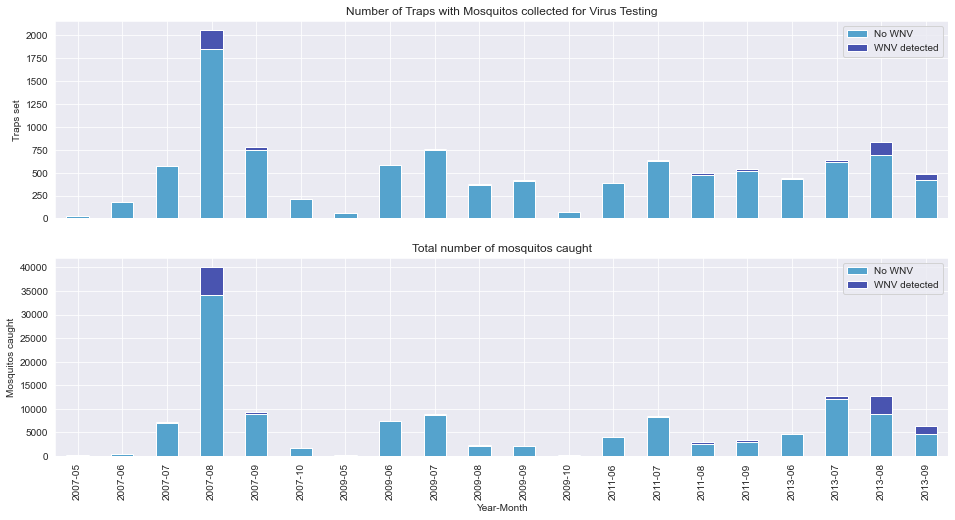

In [12]:
# Visualising trends of traps and mosquitos caught over the past few years
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16,8))

count_traps.plot(ax=axs[0], kind="bar", stacked=True)
axs[0].set_title("Number of Traps with Mosquitos collected for Virus Testing")
axs[0].set_xlabel("")
axs[0].set_ylabel("Traps set")
axs[0].legend(labels=["No WNV", "WNV detected"])

mosquitos_caught.plot(ax=axs[1], kind="bar", stacked=True)
axs[1].set_title("Total number of mosquitos caught")
axs[1].set_xlabel("Year-Month")
axs[1].set_ylabel("Mosquitos caught")
axs[1].legend(labels=["No WNV", "WNV detected"])

In [13]:
# Are there any duplicate traps placed?
nunique_traps = train['trap'].nunique()
print(f'No. of unique traps employed: {nunique_traps}\n')

# This returns the number of unique addresses tied to a specific trap
trap_addresses = train[['trap','address']].groupby(by='trap').agg({'address':pd.Series.nunique})
print(trap_addresses.loc[trap_addresses['address'] >1].reset_index())

No. of unique traps employed: 136

   trap  address
0  T009        2
1  T035        2


In [14]:
# Which addresses is trap T009 associated with?
train[train['trap']=='T009']['address'].value_counts()

9100 West Higgins Road, Rosemont, IL 60018, USA     80
9100 West Higgins Avenue, Chicago, IL 60656, USA    31
Name: address, dtype: int64

In [15]:
# Which addresses is trap T009 associated with?
train[train['trap']=='T035']['address'].value_counts()

5100 West 72nd Street, Chicago, IL 60638, USA      45
3000 South Hoyne Avenue, Chicago, IL 60608, USA    27
Name: address, dtype: int64

**Thoughts**: Both T009 and T035 appear to be associated with different unique addresses. We can safely conclude that trap identification numbers do not matter much for our dataset, given the lat/long coordinates present.

In [16]:
# We will need to adjust for duplicate records as the number of mosquitos associated with a trap is capped at 50
train = train.groupby([col for col in train.columns if col not in ['nummosquitos', 'wnvpresent']]).sum()
train.reset_index(inplace=True)

# Rejigging our wnvpresent levels
train['wnvpresent'] = train['wnvpresent'].map(lambda x : 1 if x > 0 else x)

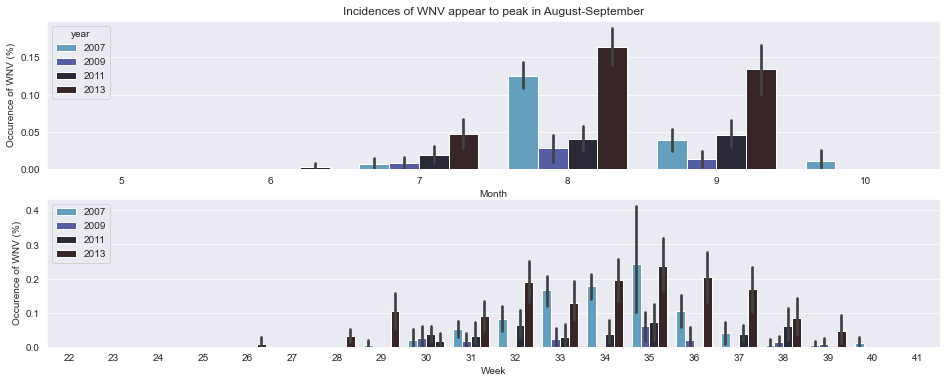

In [17]:
# Visualise occurences of WNV throughout the years
fig, axs = plt.subplots(nrows=2, figsize=(16,6))
sns.barplot(ax=axs[0], data=train, x='month', y='wnvpresent', hue='year')
axs[0].set_title("Incidences of WNV appear to peak in August-September")
axs[0].set_ylabel("Occurence of WNV (%)")
axs[0].set_xlabel("Month")

sns.barplot(ax=axs[1], data=train, x='week', y='wnvpresent', hue='year')
axs[1].set_ylabel("Occurence of WNV (%)")
axs[1].set_xlabel("Week")
plt.legend(loc="upper left")
plt.show()

**Our thoughts**: There appears to be some seasonality effects at play. Incidences of WNV appear to peak in August. We can infer that the week / month are probably drivers to monitor.

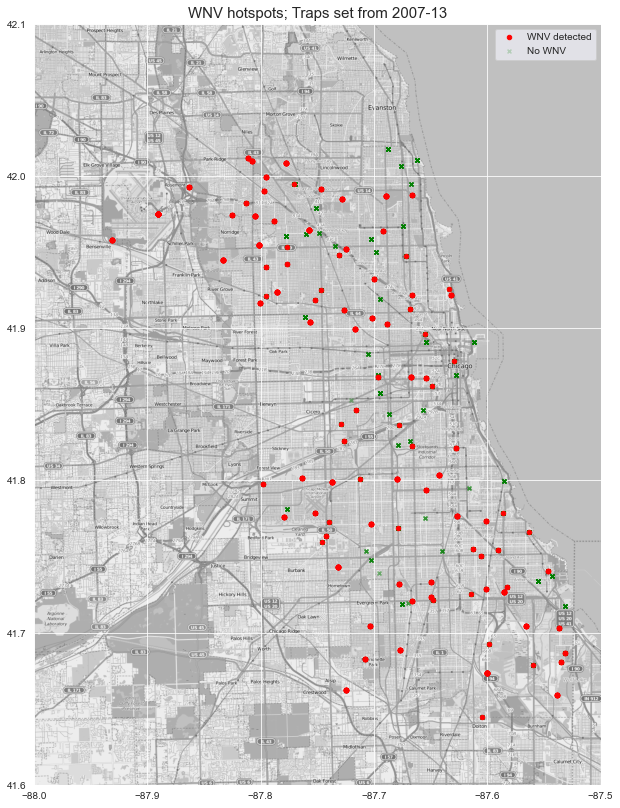

In [18]:
# Let's visualise the locations of traps, as well as the presence of the WNV
mapdata = np.loadtxt("../data/raw/mapdata_copyright_openstreetmap_contributors.txt")

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(14,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)


wnv_traps = train.loc[train["wnvpresent"]==1]
ok_traps = train.loc[train["wnvpresent"]==0]

wnv_false = plt.scatter(ok_traps['longitude'], ok_traps['latitude'], c="green", marker='x', s=15, alpha=0.2)
wnv_true = plt.scatter(wnv_traps['longitude'], wnv_traps['latitude'], c="red", marker='o', s=20, alpha=1)

plt.title("WNV hotspots; Traps set from 2007-13", fontsize=15)
plt.legend((wnv_true, wnv_false), ("WNV detected", "No WNV"));

In [19]:
# Does the species of mosquito matter?
species_wnv = train.pivot_table(values=['nummosquitos'], index='species', columns=['wnvpresent'], aggfunc='sum')

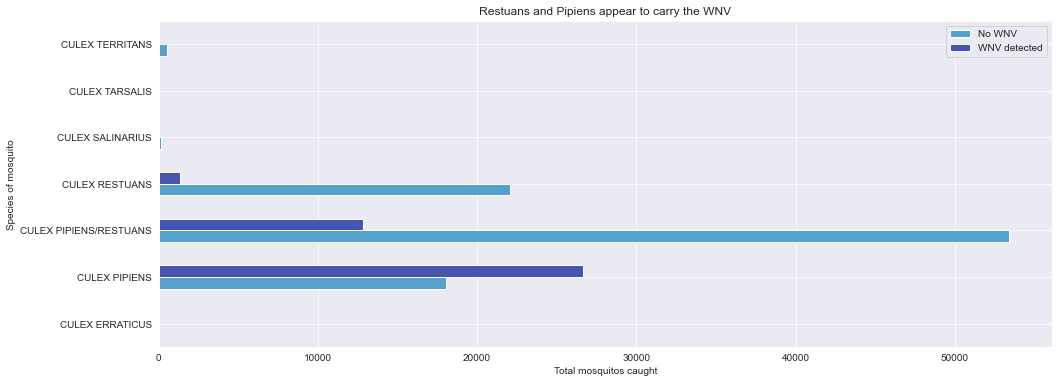

In [20]:
# Visualising the incidence of WNV in different species
g = species_wnv.plot(kind="barh", stacked=False, figsize=(16,6))
g.set_title("Restuans and Pipiens appear to carry the WNV")
g.set_xlabel("Total mosquitos caught")
g.set_ylabel("Species of mosquito")
g.legend(labels=["No WNV", "WNV detected"])

In [21]:
# We can exclude Unsepcified species from this selection
species_of_interest = ['RESTUANS', 'PIPIENS', 'SALINARIUS', 'TERRITANS', 'TARSALIS', 'ERRATICUS']

# create loop to create dummified variables to indicate presence of Pipiens & Restuans species
def dummify_species(df):
    for i in species_of_interest:
        df[i] = df['species'].apply(lambda x: 1 if i in x else 0)
    
    return df

In [22]:
# Let's one-hot encode to indicate the presence of different mosquito species in different traps
train_dum = dummify_species(train)

## Tidying / Exploring our ```weather``` dataset
The weather records provided to us are from May 2007 to October 2014. There are two weather stations capturing the data each day:
* Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
* Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

In this part of the codebook, we will focus on optimising and selecting variables that have a large part to play in aiding mosquito reproduction. Based on our research, varying temperatures have significant effects on eggs viability and hatching time, with optimal temperatures depending on species. 

**Optimal temperatures for WNV transmission**

West Nile virus spreads most efficiently in the U.S. at temperatures between 75.2 and 77 degrees Fahrenheit, a new study published in eLife shows.

**What type of mosquitos transmit the WNV?**

The primary carrier of West Nile virus is the southern house mosquito. This mosquito species breeds in polluted water commonly found in roadside ditches that receive effluent from residential filter beds and septic tanks. There are approximately 300 miles of roadside septic ditches in St. Tammany Parish. Other species that have the potential for transmitting the virus are *Culex salinarius* and *Culex nigripalpus* which both breed in fresh and brackish water commonly found in the marshes and permanent water pools. *Aedes vexans*, the inland floodwater mosquito, which breeds in temporary pools, also is capable of transmitting WNV. Finally, circumstantial evidence suggests that the Asian tiger mosquito, which breeds in artificial containers commonly found in yards, will also transmit the disease.

**Resources**:
* The role of temperature in shaping mosquito-borne viruses transmission [(link)](https://www.frontiersin.org/articles/10.3389/fmicb.2020.584846/full)
* Mosquitos and West Nile Virus: What should you know and what can you do [(link)](https://stpmad.org/wp-content/uploads/2018/10/West_Nile_virus_pamphlet.pdf)
* Rising temperatures could shift US WNV transmission [(link)](https://www.nsf.gov/discoveries/disc_summ.jsp?cntn_id=301296&org=NSF&from=news#:~:text=West%20Nile%20virus%20spreads%20most,study%20published%20in%20eLife%20shows.)

In [23]:
# Import tidied weather dataset
weather = pd.read_csv('../data/raw/weather.csv', parse_dates=["Date"])

# Converting our column names to lower-case for standardisation
weather.columns = weather.columns.str.lower()

In [24]:
# Taking a quick look at our weather dataset 
eda_clean(weather)

Dataset Statistics:
Shape of dataframe: (2944, 22)
--------------------------------------
Null values in dataframe: 0
--------------------------------------
% of Null values in dataframe: 0.0%
--------------------------------------
Total duplicate rows: 0
--------------------------------------
% duplicate rows: 0.0%

Column names: Index(['station', 'date', 'tmax', 'tmin', 'tavg', 'depart', 'dewpoint',
       'wetbulb', 'heat', 'cool', 'sunrise', 'sunset', 'codesum', 'depth',
       'water1', 'snowfall', 'preciptotal', 'stnpressure', 'sealevel',
       'resultspeed', 'resultdir', 'avgspeed'],
      dtype='object')

Variable Types
Columns Count: 
object            15
int64              5
float64            1
datetime64[ns]     1
dtype: int64


**Replacing missing ('M) values in the dataset**

In [25]:
# Replacing all missing values with np.nan
weather[weather=='M'] = np.nan

**One-hot encoding ```codesum``` values**

In [26]:
# Ensuring there is proper spacing between different weather types
weather_codes = ['+FC','FC', 'TS', 'GR', 'RA', 'DZ', 'SN', 'SG', 'GS', 'PL','IC', 'FG+', 'FG', 
                 'BR', 'UP', 'HZ', 'FU', 'VA', 'DU', 'DS', 'PO', 'SA', 'SS', 'PY', 'SQ', 'DR', 
                 'SH', 'FZ', 'MI', 'PR', 'BC', 'BL', 'VC']

weather['codesum'] = weather['codesum'].apply(lambda x: ' '.join([i for i in x.split(' ') if i in weather_codes]))

**We will need to create separate dummy variables for different conditions**

These include ```raining```,  ```snowing```,  ```windy```,  ```misty``` conditions

In [27]:
# Manual creation of dummy variables which rainy, snowy, windy and misty conditions 
weather["raining"] = np.where(weather['codesum'].str.contains("|".join(['TS', 'RA', 'DZ', 'SH'])), 1, 0)
weather["snowing"] = np.where(weather['codesum'].str.contains("|".join(['SN', 'SG', 'GS', 'PL', 'IC', 'DR', 'BC', 'GR'])), 1, 0)
weather["windy"] = np.where(weather['codesum'].str.contains("|".join(['SQ', 'DS', 'SS', 'PO', 'BL'])), 1, 0)
weather["misty"] = np.where(weather['codesum'].str.contains("|".join(['BR', 'HZ', 'FG', 'FU'])), 1, 0)

On hindsight, a large part of significant weather conditions is rain, which may be captured in total precipitation. We could drop the remaining columns.

**Tidying / Fixing missing ```tavg``` values**

In [28]:
## We can manually inpute missing tavg values
weather['tavg'][weather['tavg'].isna()] = 0.5*(weather['tmax'][weather['tavg'].isna()] + weather['tmin'][weather['tavg'].isna()])

**Tidying / Fixing ```preciptotal``` values that are shown as trace amounts (i.e. T)**

In [29]:
# We can manually inpute missing preciptotal
weather.loc[weather['preciptotal'] == ("  T" or "T")].head()

station       date  tmax  tmin tavg depart  dewpoint wetbulb heat cool  \
6         1 2007-05-04    66    49   58      4        41      50    7    0   
8         1 2007-05-05    66    53   60      5        38      49    5    0   
9         2 2007-05-05    66    54   60    NaN        39      50    5    0   
12        1 2007-05-07    83    47   65     10        41      54    0    0   
15        2 2007-05-08    80    60   70    NaN        57      63    0    5   

    ... preciptotal stnpressure sealevel resultspeed resultdir avgspeed  \
6   ...           T       29.31    30.05        10.4         8     10.8   
8   ...           T       29.40    30.10        11.7         7     12.0   
9   ...           T       29.46    30.09        11.2         7     11.5   
12  ...           T       29.38    30.12         8.6        18     10.5   
15  ...           T       29.36    30.02         2.5         8      5.4   

   raining snowing windy  misty  
6        1       0     0      0  
8        0       0     0      0  
9        0       0     0      0  
12       1       0     0      0  
15       0       0     0      1  

[5 rows x 26 columns]

In [30]:
# We can safely assume that if the codesum does not indicate a significant weather type, we can assume preciptotal = 0
weather['preciptotal'] = [0 if i in ["T", "  T"] else i for i in weather['preciptotal']]

**Tidying / Fixing missing ```stnpressure``` values**

In [31]:
## Let's tidy stnpressure using the median corresponding to the dataset
imputed_stnpressure = {}
for i in weather['station'].unique():
    imputed_stnpressure[i] = weather[weather['station'] == i]['stnpressure'].median()

In [32]:
# We can imput the stnpressure by using the median values from different weather conditions
weather['stnpressure'][weather['stnpressure'].isna()] = weather['station'][weather['stnpressure'].isna()].map(imputed_stnpressure)

**Tidying / Fixing missing ```sealevel``` values**

In [33]:
## Let's tidy sealevel using the median corresponding to the dataset
imputed_sealevel = {}
for i in weather['station'].unique():
    imputed_sealevel[i] = weather[weather['station'] == i]['sealevel'].median()

In [34]:
# We can imput the sealevel by using the median values from different weather conditions
weather['sealevel'][weather['sealevel'].isna()] = weather['station'][weather['sealevel'].isna()].map(imputed_stnpressure)

**Tidying / Fixing missing ```avgspeed``` values**

In [35]:
## Let's tidy avgspeed using the median corresponding to the dataset
imputed_avgspeed = {}
for i in weather['codesum'].unique():
    imputed_avgspeed[i] = weather[weather['codesum'] == i]['avgspeed'].median()

In [36]:
# We can imput the acgspeed by using the median values from different weather conditions
weather['avgspeed'][weather['avgspeed'].isna()] = weather['codesum'][weather['avgspeed'].isna()].map(imputed_avgspeed)

**Ensuring datatypes are representative / Deciding which columns to keep**

In [37]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   station      2944 non-null   int64         
 1   date         2944 non-null   datetime64[ns]
 2   tmax         2944 non-null   int64         
 3   tmin         2944 non-null   int64         
 4   tavg         2944 non-null   object        
 5   depart       1472 non-null   object        
 6   dewpoint     2944 non-null   int64         
 7   wetbulb      2940 non-null   object        
 8   heat         2933 non-null   object        
 9   cool         2933 non-null   object        
 10  sunrise      2944 non-null   object        
 11  sunset       2944 non-null   object        
 12  codesum      2944 non-null   object        
 13  depth        1472 non-null   object        
 14  water1       0 non-null      object        
 15  snowfall     1472 non-null   object        
 16  precip

In [38]:
weather[['tavg', 'preciptotal', 
         'stnpressure', 'sealevel', 
         'avgspeed']] = weather[['tavg', 'preciptotal', 
                                 'stnpressure', 'sealevel', 
                                 'avgspeed']].astype(float)

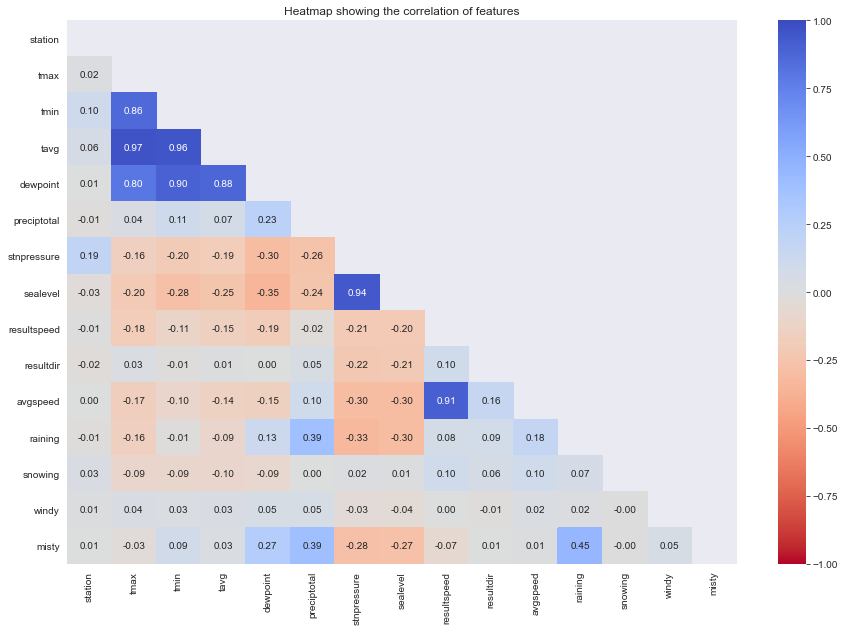

Wall time: 1.68 s


In [39]:
%%time

# Let's plot a heatmap to look at the correlation matrix of the selected variables
## Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(weather.corr())

# using the upper triangle matrix as mask 
plt.figure(figsize=(15,10))
plt.title("Heatmap showing the correlation of features")
sns.heatmap(weather.corr(), annot=True, mask= matrix, cmap="coolwarm_r", 
           fmt=".2f", annot_kws={"size":10}, vmin=-1, vmax=1)
plt.show()

### More feature engineering
* Humidity
* The interaction between temperature and total precipitation
* Lagging weather measurements
* Temperature range
* Daylight exposure

**Creation of humidity variable**

In [40]:
# Feature Engineering #1: Relative humdity
weather['humidity'] = 100*(np.exp((17.67 * ((weather['dewpoint'] - 32) * (5/9))) / 
                                           (243.5 + ((weather['dewpoint'] - 32) * (5/9)))) 
                                    /
                                    np.exp((17.67 * ((weather['tavg'] - 32) * (5/9))) /
                                           (243.5 + ((weather['tavg'] - 32) * (5/9)))))

**Creation of daily temperature range variable**

In [41]:
# Feature engineering #2: Temperature range
weather['trange'] = weather['tmax'] - weather['tmin']

**Creation of daylight mins variable**

In [42]:
# # Feature engineering #3: Daylight hours
# station1 = weather.loc[weather['station']==1] # Only station 1 records sunset / sunrise hours

# # Converting to the right format
# station1['sunset'] = station1['sunset'].map(lambda x : (str(int(x[0:2]) + 1) + '00') if x[2:4] == '60' else x)
# station1['sunrise'] = station1['sunrise'].map(lambda x : (str(int(x[0:2]) + 1) + '00') if x[2:4] == '60' else x)

In [43]:
# # Calculating daylight time in minutes
# station1['sunset_t'] = station1['sunset'].map(lambda x : dt.datetime.strptime(x, '%H%M'))
# station1['sunrise_t'] = station1['sunrise'].map(lambda x : dt.datetime.strptime(x, '%H%M'))
# station1['daylight_mins'] = (station1['sunset_t'] - station1['sunrise_t']).map(lambda x : x.seconds / 60)

In [44]:
# # Merging back with the actual dataset
# weather = weather.merge(station1[['date', 'daylight_mins']], on="date")

In [45]:
# We can now drop sunrise and sunset columns
weather.drop(columns=['sunrise', 'sunset', 'windy', 'snowing'], inplace=True)

**Creation of lagged weather statistics**

Columns to average include: ```tmax```, ```tmin```, ```tavg```, ```dewpoint```, ```stnpressure```, ```sealevel```, ```avgspeed```, ```humidity```

Columns to sum include: ```preciptotal```, ```raining```, ```misty```, ```daylight_mins```

In [46]:
# Defining our columns of interest
## Columns to compute 5/10-day moving averages
cols_to_average = ['tavg', 'trange', 'stnpressure', 'avgspeed', 'humidity', 'preciptotal']

## Columns to compute 5/10-day moving averages
cols_to_sum = ['preciptotal', 'raining', 'misty']

# Creation of sub-groups filtered by station
station1 = weather.loc[weather['station']==1].set_index('date')
station2 = weather.loc[weather['station']==2].set_index('date')

In [47]:
# 5-day rolling averages
station1_5ma = station1[cols_to_average].rolling(5).mean()
station1_5ma['station'] = 1
station2_5ma = station2[cols_to_average].rolling(5).mean()
station2_5ma['station'] = 2

# Merging rolling averages from both sub-groups
stations_5ma = pd.concat([station1_5ma, station2_5ma], axis=0)

# 10-day rolling averages
station1_10ma = station1[cols_to_average].rolling(10).mean()
station1_10ma['station'] = 1
station2_10ma = station2[cols_to_average].rolling(10).mean()
station2_10ma['station'] = 2

# Merging rolling averages from both sub-groups
stations_10ma = pd.concat([station1_10ma, station2_10ma], axis=0)

# Combining these rolling averages with the overall weather dataset
weather = weather.merge(stations_5ma, on=['date', 'station'], how='left', suffixes=["", "_5ma"])
weather = weather.merge(stations_10ma, on=['date', 'station'], how='left', suffixes=["", "_10ma"])

In [48]:
# 5-day rolling sums
station1_5sum = station1[cols_to_sum].rolling(5).sum()
station1_5sum['station'] = 1
station2_5sum = station2[cols_to_sum].rolling(5).sum()
station2_5sum['station'] = 2

# Merging rolling sums from both sub-groups
stations_5sum = pd.concat([station1_5sum, station2_5sum], axis=0)

# 10-day rolling sums
station1_10sum = station1[cols_to_sum].rolling(10).sum()
station1_10sum['station'] = 1
station2_10sum = station2[cols_to_sum].rolling(10).sum()
station2_10sum['station'] = 2

# Merging rolling sums from both sub-groups
stations_10sum = pd.concat([station1_10sum, station2_10sum], axis=0)

# Combining these rolling averages with the overall weather dataset
weather = weather.merge(stations_5sum, on=['date', 'station'], how='left', suffixes=["", "_5sum"])
weather = weather.merge(stations_10sum, on=['date', 'station'], how='left', suffixes=["", "_10sum"])

In [49]:
# Dropping columns we do not need
weather.drop(columns=['depart', 'wetbulb', 'heat', 'cool', 'codesum', 'depth',
                      'resultspeed', 'resultdir', 'water1', 'snowfall', 'dewpoint', 
                      'sealevel', 'tmax', 'tmin'], inplace=True)

In [50]:
# Previewing our final weather dataframe
weather.head()

station       date  tavg  preciptotal  stnpressure  avgspeed  raining  \
0        1 2007-05-01  67.0          0.0        29.10       9.2        0   
1        2 2007-05-01  68.0          0.0        29.18       9.6        0   
2        1 2007-05-02  51.0          0.0        29.38      13.4        0   
3        2 2007-05-02  52.0          0.0        29.44      13.4        0   
4        1 2007-05-03  56.0          0.0        29.39      11.9        0   

   misty   humidity  trange  ...  stnpressure_10ma  avgspeed_10ma  \
0      0  56.410238      33  ...               NaN            NaN   
1      0  54.497276      32  ...               NaN            NaN   
2      1  71.176939      17  ...               NaN            NaN   
3      1  68.594699      17  ...               NaN            NaN   
4      0  54.848860      20  ...               NaN            NaN   

   humidity_10ma  preciptotal_10ma  preciptotal_5sum  raining_5sum  \
0            NaN               NaN               NaN           NaN   
1            NaN               NaN               NaN           NaN   
2            NaN               NaN               NaN           NaN   
3            NaN               NaN               NaN           NaN   
4            NaN               NaN               NaN           NaN   

   misty_5sum  preciptotal_10sum  raining_10sum  misty_10sum  
0         NaN                NaN            NaN          NaN  
1         NaN                NaN            NaN          NaN  
2         NaN                NaN            NaN          NaN  
3         NaN                NaN            NaN          NaN  
4         NaN                NaN            NaN          NaN  

[5 rows x 28 columns]

In [51]:
# Saving our tidied weather dataframe for use later
weather.to_csv('../data/cleaned/weather_tidied.csv', index=False)

## Merging ```weather``` and ```train``` datasets

In [52]:
# We will need to create our own function to assign observations
def determine_station(lat, long):
    station1 = (41.995, -87.933) #Chicago O'Hare Tntl Airpot -> lat: 41.995 long: -87.933
    station2 = (41.786, -87.752) #Chicago Midway Tntl Airpot -> lat: 41.786 long: -87.752
    coordinates = (lat, long)
    return 1 if geodesic(coordinates, station1) < geodesic(coordinates, station2) else 2

In [53]:
%%time

# Apply function to map our function
train_dum['station_ref'] = train_dum.apply(lambda i: determine_station(i['latitude'], i['longitude']), axis=1)

Wall time: 4.42 s


In [54]:
train_combined = train.merge(weather, how='left',
                            left_on=['station_ref', 'date'],
                            right_on=['station', 'date'])

In [55]:
# Previewing our final dataset
eda_clean(train_combined)

Dataset Statistics:
Shape of dataframe: (8475, 51)
--------------------------------------
Null values in dataframe: 280
--------------------------------------
% of Null values in dataframe: 3.3%
--------------------------------------
Total duplicate rows: 0
--------------------------------------
% duplicate rows: 0.0%

Column names: Index(['date', 'address', 'species', 'block', 'street', 'trap',
       'addressnumberandstreet', 'latitude', 'longitude', 'addressaccuracy',
       'year', 'month', 'week', 'day', 'year_month', 'nummosquitos',
       'wnvpresent', 'RESTUANS', 'PIPIENS', 'SALINARIUS', 'TERRITANS',
       'TARSALIS', 'ERRATICUS', 'station_ref', 'station', 'tavg',
       'preciptotal', 'stnpressure', 'avgspeed', 'raining', 'misty',
       'humidity', 'trange', 'tavg_5ma', 'trange_5ma', 'stnpressure_5ma',
       'avgspeed_5ma', 'humidity_5ma', 'preciptotal_5ma', 'tavg_10ma',
       'trange_10ma', 'stnpressure_10ma', 'avgspeed_10ma', 'humidity_10ma',
       'preciptotal_10ma', '

In [56]:
# We can drop a number of redundant columns
cols_to_drop = ['address', 'species', 'block', 'street', 'trap', 'addressaccuracy', 
                'latitude', 'longitude', 
#                 'day',
                'nummosquitos']

In [57]:
train_combined.drop(columns=cols_to_drop, inplace=True)

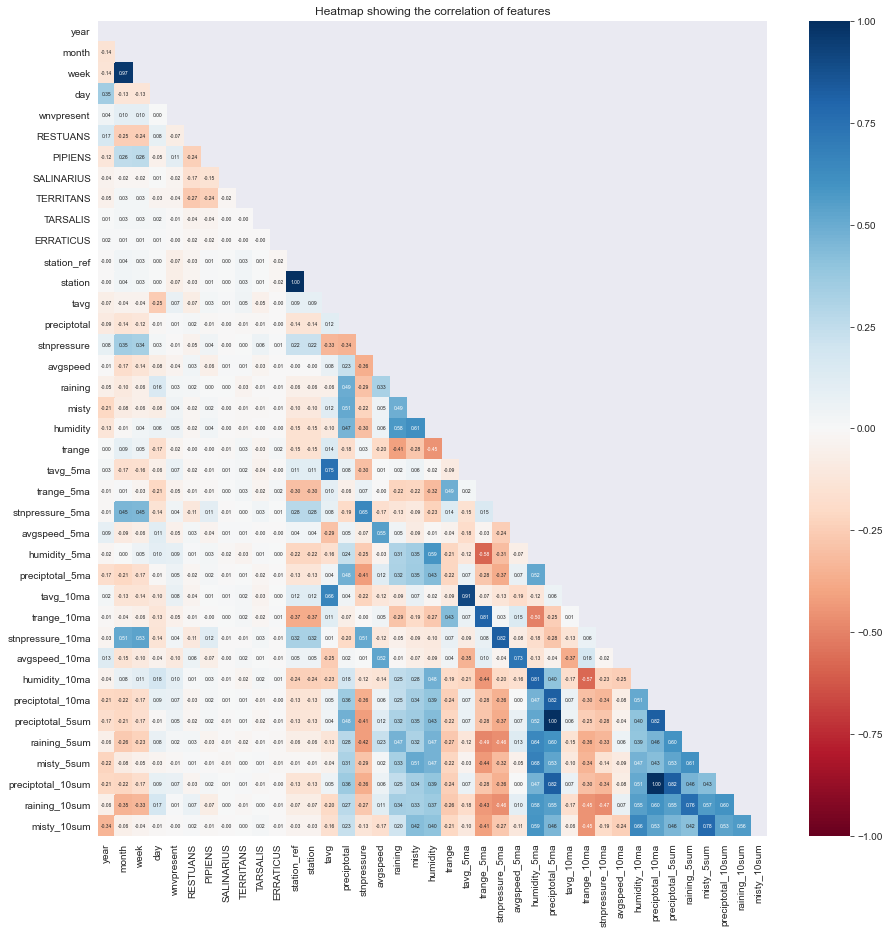

Wall time: 6.81 s


In [58]:
%%time

# Let's plot a heatmap to look at the correlation matrix of the selected variables
## Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(train_combined.corr())

# using the upper triangle matrix as mask 
plt.figure(figsize=(15,15))
plt.title("Heatmap showing the correlation of features")
sns.heatmap(train_combined.corr(), annot=True, mask= matrix, cmap="RdBu", 
           fmt=".2f", annot_kws={"size":5}, vmin=-1, vmax=1)
plt.show()

<AxesSubplot:>

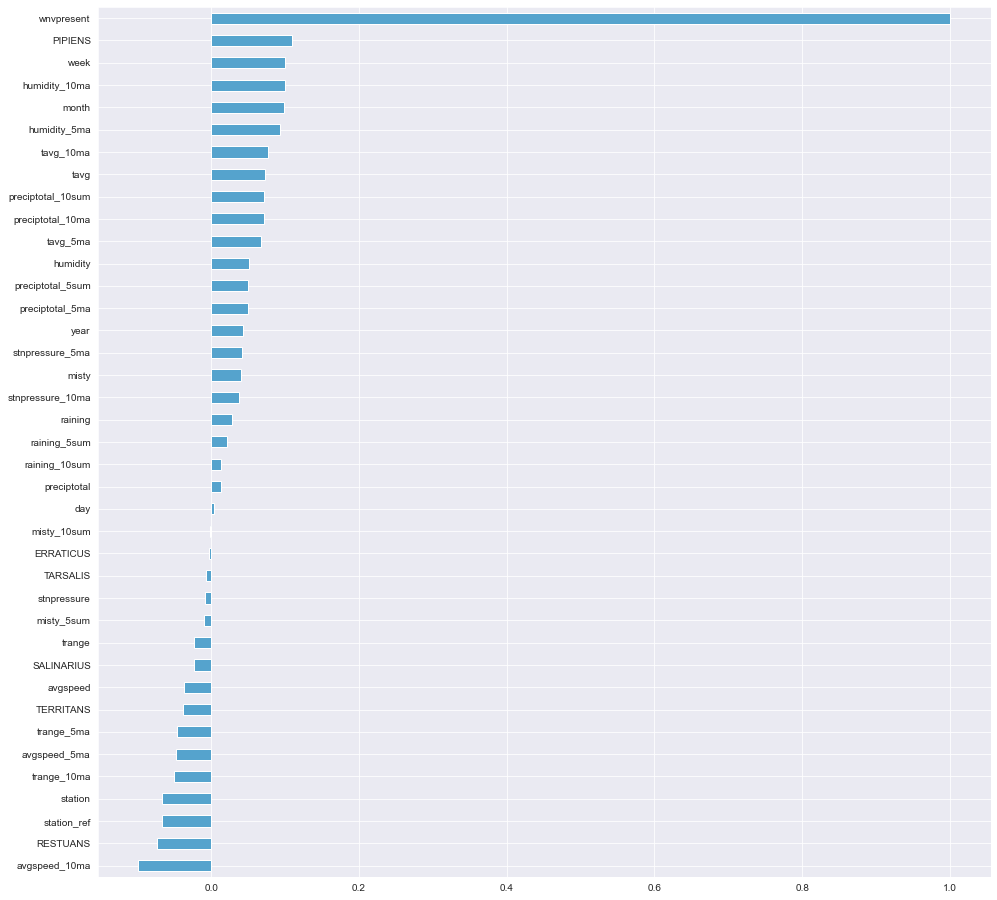

In [59]:
# Zooming in
plt.figure(figsize=(16, 16))
train_combined.corr()['wnvpresent'].sort_values().plot(kind="barh")

In [60]:
train_combined.to_csv('../data/cleaned/train_tidied.csv', index=False)

## Tidying / Exploring our ```spray``` dataset

In [61]:
# Import Kaggle spray.csv
spray = pd.read_csv('../data/raw/spray.csv', parse_dates=['Date'])

# Converting our column names to lowercase for standardization
spray.columns = spray.columns.str.lower()

In [62]:
# Taking a quick look at our spray dataset
eda_clean(spray)

Dataset Statistics:
Shape of dataframe: (14835, 4)
--------------------------------------
Null values in dataframe: 584
--------------------------------------
% of Null values in dataframe: 3.94%
--------------------------------------
Total duplicate rows: 541
--------------------------------------
% duplicate rows: 3.65%

Column names: Index(['date', 'time', 'latitude', 'longitude'], dtype='object')

Variable Types
Columns Count: 
float64           2
datetime64[ns]    1
object            1
dtype: int64


In [63]:
# Let's check out the duplicated rows
spray[spray.duplicated()].head()

date        time   latitude  longitude
485 2011-09-07  7:43:40 PM  41.983917 -87.793088
490 2011-09-07  7:44:32 PM  41.986460 -87.794225
491 2011-09-07  7:44:32 PM  41.986460 -87.794225
492 2011-09-07  7:44:32 PM  41.986460 -87.794225
493 2011-09-07  7:44:32 PM  41.986460 -87.794225

**Thoughts**: There a total of 541 duplicate records for spray. Perhaps this may have been a way to indicate the total dosage relative to a single location. We're just speculating here... but as a large portion of these duplicates appear to correspond to a single date-time entry, we can assume that these are likely data collection errors.

**Proposed action**: We will drop duplicate rows

In [64]:
# Dropping duplicate rows
print(f"Spray dimensions: {spray.shape}")
spray.drop_duplicates(keep='first', inplace=True)
print(f"Amended spray dimensions: {spray.shape}")

Spray dimensions: (14835, 4)
Amended spray dimensions: (14294, 4)


In [65]:
# Where are the missing values located?
spray.isnull().sum()/len(spray)*100

date         0.00000
time         4.08563
latitude     0.00000
longitude    0.00000
dtype: float64

**Thoughts**: *Null* values are concentrated within the ```time``` column, which might be a tad too granular for us.

**Proposed action**: We will drop the ```time``` column from the ```spray``` dataset.

In [66]:
# We can drop the time column as it is not a key driver for us
spray.drop(columns='time', inplace=True)

In [67]:
# Let's see the trajectory of sprays in recent years
spray_ts = spray.groupby('date').size()

**Visualising spraying trends over the past few years**

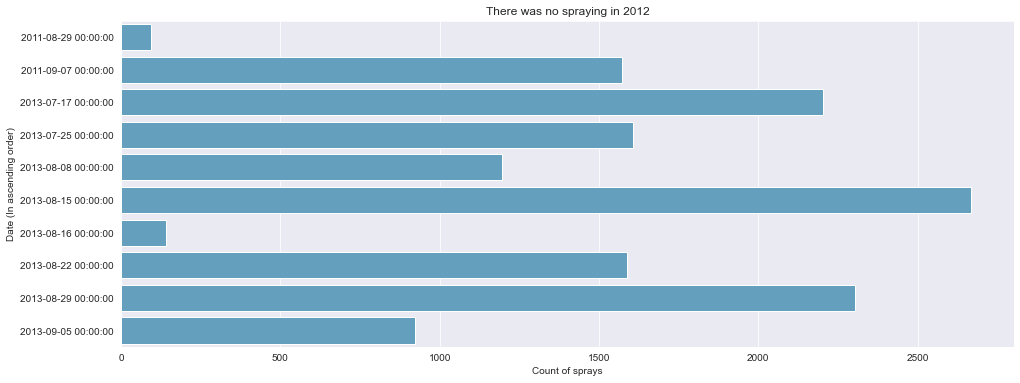

In [68]:
# Charting our time-series
plt.figure(figsize=(16, 6))
sns.barplot(y=spray_ts.index, x=spray_ts.values, color=sns.color_palette('icefire')[0])
plt.title("There was no spraying in 2012")
plt.xlabel("Count of sprays")
plt.ylabel("Date (In ascending order)")
plt.show()

**Thoughts**: Bulk of spray efforts took place in 2013, especially during the months of July-September. There also was no spraying in 2012. More work needs to be done as there may be seasonality factors at play.

**Visualising spraying trends over the past few years; Utilising mapdata**

The map files mapdata_copyright_openstreetmap_contributors.rds and mapdata_copyright_openstreetmap_contributors.txt are from Open Streetmap. We will be utilising them in our visualisations.

In [69]:
# Filtering some outliers (We've realised this after plotting)
spray[['latitude', 'longitude']].describe()

latitude     longitude
count  14294.000000  14294.000000
mean      41.901739    -87.734512
std        0.105100      0.067599
min       41.713925    -88.096468
25%       41.782669    -87.789607
50%       41.937578    -87.724781
75%       41.977217    -87.692107
max       42.395983    -87.586727

In [70]:
# Removing sprays that occured outside of the parameters provided in the map
spray_filtered = spray.loc[spray['latitude'] < 42.1]

In [71]:
# Let's plot where sprays have been in the past
mapdata_txt = np.loadtxt('../data/raw/mapdata_copyright_openstreetmap_contributors.txt')

aspect = mapdata_txt.shape[0] * 1.0 / mapdata_txt.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

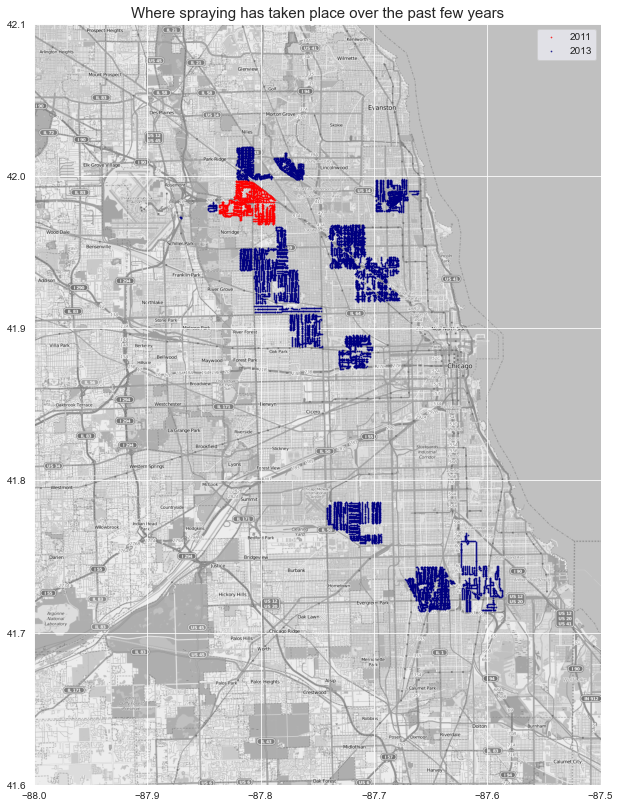

In [72]:
plt.figure(figsize=(14,14))
plt.imshow(mapdata_txt, cmap=plt.get_cmap('gray'), extent=lon_lat_box, aspect=aspect)

spray_filtered['year'] = spray_filtered['date'].dt.year
spray_2011 = spray_filtered.loc[spray_filtered['year']==2011]
spray_2013 = spray_filtered.loc[spray_filtered['year']==2013]
spray_filtered.drop(['year'], axis=1, inplace=True)

spray_2011_chart = plt.scatter(spray_2011['longitude'], spray_2011['latitude'], 
                               c='red', marker='x', s=0.5, alpha=0.8, label ='2011')

spray_2013_chart = plt.scatter(spray_2013['longitude'], spray_2013['latitude'], 
                               c='navy', marker='o', s=0.5, alpha=0.8, label='2013')

plt.title('Where spraying has taken place over the past few years', fontsize=15)
plt.legend()
plt.show();

In [73]:
# Saving our spray dataset for use later
spray.to_csv('../data/cleaned/spray_tidied.csv', index=False)